In [12]:
!pip install numpy==1.26.4 --force-reinstall --no-cache-dir -q
!pip install transformers==4.36.2 sentencepiece scikit-learn==1.2.2 lightgbm imbalanced-learn shap tqdm matplotlib seaborn -q


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 240.1 MB/s eta 0:00:00a 0:00:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
datasets 4.4.1 requires pyarrow>=21.0.0, but you have pyarrow 19.0.1 which is incompatible.
ydata-profiling 4.17.0 requires scipy<1.16,>=1.4.1, but you have scipy 1.16.3 which is incompatible.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
google-colab 1.0.0 requires notebook==6.5.7, but you have notebook 6.5.4 which is incompatible.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.
google-colab 1.0.0 requires requests==2.32.3, but you have requests 2.32.5 which is incomp

In [14]:
import numpy as np
import pandas as pd
import torch
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, classification_report, confusion_matrix
)

from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb

from imblearn.over_sampling import RandomOverSampler, SMOTE

import shap
from scipy.stats import ttest_rel, f_oneway, wilcoxon

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

DATASET_PATH  = "/kaggle/input/datsset-beforeprocessing/DataSet_beforeProcessing.csv"
TEXT_COLUMN   = "statement"
LABEL_COLUMN  = "status"


Using device: cuda


In [15]:
df = pd.read_csv(DATASET_PATH)[[TEXT_COLUMN, LABEL_COLUMN]].dropna().reset_index(drop=True)
df[TEXT_COLUMN] = df[TEXT_COLUMN].astype(str)

print(df.head())
print("Shape:", df.shape)
print("Class counts:\n", df[LABEL_COLUMN].value_counts())

X_text = df[TEXT_COLUMN].values
y      = df[LABEL_COLUMN].values

X_train_text, X_test_text, y_train, y_test = train_test_split(
    X_text, y, test_size=0.2, stratify=y, random_state=42
)

print("Train size:", len(X_train_text))
print("Test  size:", len(X_test_text))


                                           statement   status
0                                         oh my gosh  Anxiety
1  trouble sleeping, confused mind, restless hear...  Anxiety
2  All wrong, back off dear, forward doubt. Stay ...  Anxiety
3  I've shifted my focus to something else but I'...  Anxiety
4  I'm restless and restless, it's been a month n...  Anxiety
Shape: (52681, 2)
Class counts:
 status
Normal                  16343
Depression              15404
Suicidal                10652
Anxiety                  3841
Bipolar                  2777
Stress                   2587
Personality disorder     1077
Name: count, dtype: int64
Train size: 42144
Test  size: 10537


In [16]:
tfidf = TfidfVectorizer(
    max_features=15000,
    ngram_range=(1, 2),
    min_df=2
)

X_tfidf_train = tfidf.fit_transform(X_train_text)
X_tfidf_test  = tfidf.transform(X_test_text)

print("TF-IDF shapes:", X_tfidf_train.shape, X_tfidf_test.shape)

svd = TruncatedSVD(n_components=300, random_state=42)
X_tfidf_train_svd = svd.fit_transform(X_tfidf_train)
X_tfidf_test_svd  = svd.transform(X_tfidf_test)

print("TF-IDF SVD shapes:", X_tfidf_train_svd.shape, X_tfidf_test_svd.shape)


TF-IDF shapes: (42144, 15000) (10537, 15000)
TF-IDF SVD shapes: (42144, 300) (10537, 300)


In [17]:
X_bert_train = pd.read_csv("/kaggle/input/bert-train-embeddings/bert_train_embeddings.csv").values
X_bert_test  = pd.read_csv("/kaggle/input/bert-test-embeddings/bert_test_embeddings.csv").values

print(X_bert_train.shape)


(42144, 768)


In [18]:
X_hybrid_train = np.hstack([X_bert_train, X_tfidf_train_svd])
X_hybrid_test  = np.hstack([X_bert_test,  X_tfidf_test_svd])

print("Hybrid shapes:", X_hybrid_train.shape, X_hybrid_test.shape)


Hybrid shapes: (42144, 1068) (10537, 1068)


In [19]:
def build_stacking_model(random_state=42):
    base_estimators = [
        ("lgbm", lgb.LGBMClassifier(
            n_estimators=200,
            learning_rate=0.05,
            num_leaves=31,
            objective="multiclass",
            random_state=random_state
        )),
        ("rf", RandomForestClassifier(
            n_estimators=200,
            n_jobs=-1,
            random_state=random_state
        )),
    ]

    final_estimator = LogisticRegression(
        max_iter=300,
        n_jobs=-1,
        multi_class="multinomial",
        solver="lbfgs"
    )

    model = StackingClassifier(
        estimators=base_estimators,
        final_estimator=final_estimator,
        stack_method="predict_proba",
        n_jobs=-1
    )
    return model


In [20]:
def evaluate_model(model, X_test, y_test, name="Model"):
    y_pred = model.predict(X_test)

    acc  = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average="macro", zero_division=0)
    rec  = recall_score(y_test, y_pred, average="macro", zero_division=0)
    f1   = f1_score(y_test, y_pred, average="macro", zero_division=0)

    print(f"\n=== {name} ===")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-score : {f1:.4f}\n")

    print("Classification report:\n")
    print(classification_report(y_test, y_pred, zero_division=0))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

    return y_pred, f1


TF-IDF(SVD) + ROS + Stacking

BERT + ROS + Stacking

Hybrid + SMOTE + Stacking

Final: Hybrid + ROS + Stacking

Running ablations & final model:   0%|          | 0/4 [00:00<?, ?it/s]



------ Ablation 1: TF-IDF (SVD) + ROS + Stacking ------
Balanced train shape: (91518, 300), sampler: RandomOverSampler
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.751917 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.766681 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Number of data points in the train set: 73214, number of used features: 300
[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Start training from score -1.945924
[LightGBM] [Info] Start training from score -1.945924
[LightGBM] [Info] Start training from score -1.945924
[LightGBM] [Info] Start training from score -1.945924
[LightGBM] [Info] Start training from score -1.945924
[LightGBM] [Info] Start training from score -1.945924
[LightGBM] [Info] Start training from score -1.945828
[LightGBM] [I

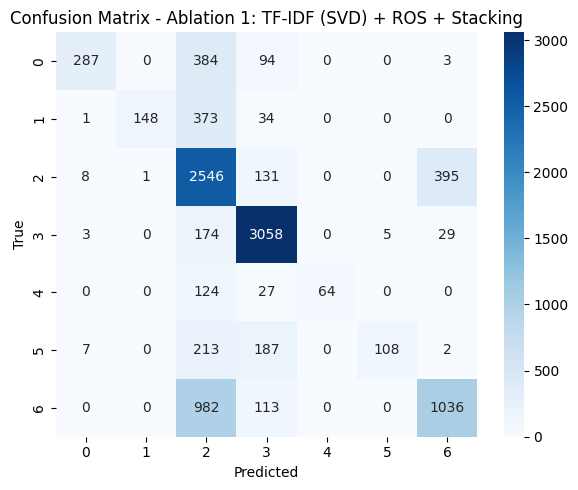



------ Ablation 2: BERT + ROS + Stacking ------
Balanced train shape: (91518, 768), sampler: RandomOverSampler
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 2.110448 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 91518, number of used features: 768
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 3.026509 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] A

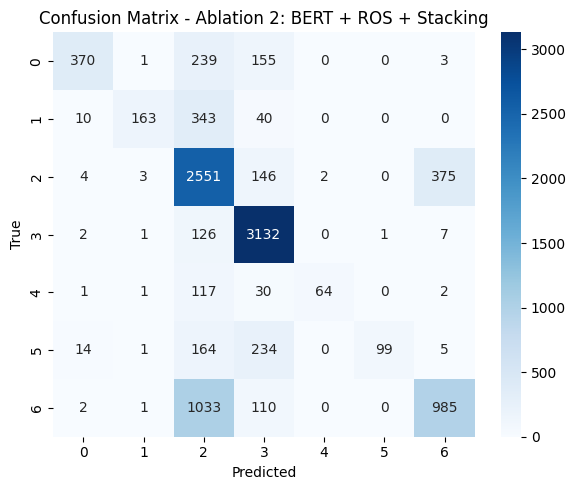



------ Ablation 3: Hybrid (BERT + TF-IDF SVD) + SMOTE + Stacking ------


Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x7a782888a160>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 1005, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 1187, in _make_controller_from_path
    lib_controller = controller_class(
                     ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 114, in __init__
    self.dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/ctypes/__init__.py", line 376, in __init__
    self._handle = _dlopen(self._name, mode)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^
OSError: dlopen() error


Balanced train shape: (91518, 1068), sampler: SMOTE
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 4.416981 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 272340
[LightGBM] [Info] Number of data points in the train set: 73214, number of used features: 1068
[LightGBM] [Info] Start training from score -1.945924
[LightGBM] [Info] Start training from score -1.945924
[LightGBM] [Info] Start training from score -1.945924
[LightGBM] [Info] Start training from score -1.945924
[LightGBM] [Info] Start training from score -1.945924
[LightGBM] [Info] Start training from score -1.945828
[LightGBM] [Info] Start training from score -1.945924
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 4.621465 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 272340
[LightGBM] [Info] Number of data points in the train set: 73214, number of used

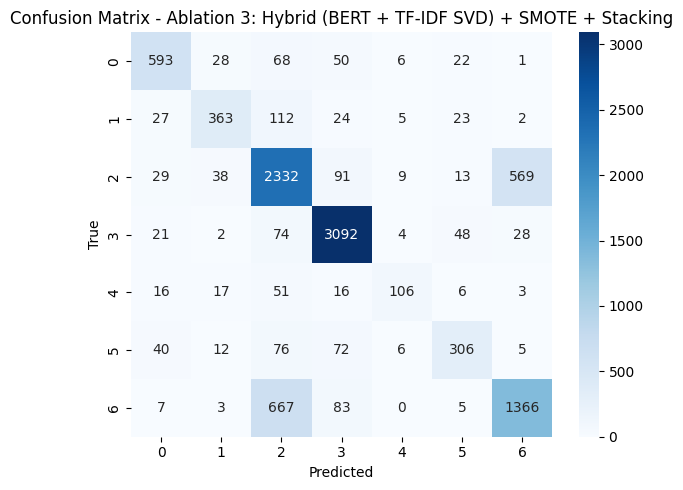



------ FINAL: Hybrid (BERT + TF-IDF SVD) + ROS + Stacking ------
Balanced train shape: (91518, 1068), sampler: RandomOverSampler
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 4.184664 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 272340
[LightGBM] [Info] Number of data points in the train set: 73214, number of used features: 1068
[LightGBM] [Info] Start training from score -1.945924
[LightGBM] [Info] Start training from score -1.945924
[LightGBM] [Info] Start training from score -1.945924
[LightGBM] [Info] Start training from score -1.945924
[LightGBM] [Info] Start training from score -1.945924
[LightGBM] [Info] Start training from score -1.945924
[LightGBM] [Info] Start training from score -1.945828
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 4.591782 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 272340


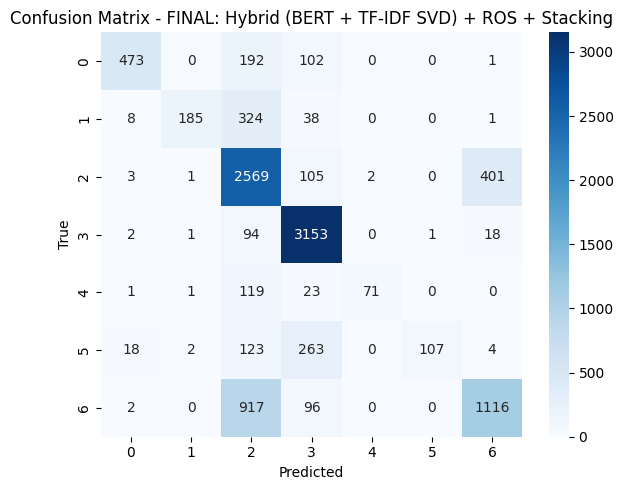


Summary F1 scores:
tfidf_ros: 0.5519
bert_ros: 0.5665
hybrid_smote: 0.7241
hybrid_ros: 0.6098


In [21]:
ros   = RandomOverSampler(random_state=42)
smote = SMOTE(random_state=42)

results_preds = {}
results_f1    = {}

experiments = [
    {
        "name": "Ablation 1: TF-IDF (SVD) + ROS + Stacking",
        "key":  "tfidf_ros",
        "X_train": X_tfidf_train_svd,
        "X_test":  X_tfidf_test_svd,
        "sampler": ros
    },
    {
        "name": "Ablation 2: BERT + ROS + Stacking",
        "key":  "bert_ros",
        "X_train": X_bert_train,
        "X_test":  X_bert_test,
        "sampler": ros
    },
    {
        "name": "Ablation 3: Hybrid (BERT + TF-IDF SVD) + SMOTE + Stacking",
        "key":  "hybrid_smote",
        "X_train": X_hybrid_train,
        "X_test":  X_hybrid_test,
        "sampler": smote
    },
    {
        "name": "FINAL: Hybrid (BERT + TF-IDF SVD) + ROS + Stacking",
        "key":  "hybrid_ros",
        "X_train": X_hybrid_train,
        "X_test":  X_hybrid_test,
        "sampler": ros
    },
]

for exp in tqdm(experiments, desc="Running ablations & final model"):
    name   = exp["name"]
    key    = exp["key"]
    X_tr   = exp["X_train"]
    X_te   = exp["X_test"]
    sampler = exp["sampler"]

    print(f"\n\n------ {name} ------")
    X_bal, y_bal = sampler.fit_resample(X_tr, y_train)
    print(f"Balanced train shape: {X_bal.shape}, sampler: {sampler.__class__.__name__}")

    model = build_stacking_model(random_state=123)
    model.fit(X_bal, y_bal)

    y_pred, f1 = evaluate_model(model, X_te, y_test, name=name)

    results_preds[key] = y_pred
    results_f1[key]    = f1

print("\nSummary F1 scores:")
for k, v in results_f1.items():
    print(f"{k}: {v:.4f}")


Statistical significance: bootstrap + t-test + ANOVA + Wilcoxon + Cohen’s d

In [22]:
def bootstrap_f1(y_true, y_pred, n_boot=200, random_state=42):
    rng = np.random.RandomState(random_state)
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    n = len(y_true)
    scores = []
    for _ in tqdm(range(n_boot), desc="Bootstrapping F1"):
        idx = rng.randint(0, n, n)
        scores.append(f1_score(y_true[idx], y_pred[idx], average="macro", zero_division=0))
    return np.array(scores)

boot_tfidf   = bootstrap_f1(y_test, results_preds["tfidf_ros"],   n_boot=200, random_state=1)
boot_bert    = bootstrap_f1(y_test, results_preds["bert_ros"],    n_boot=200, random_state=2)
boot_hybridR = bootstrap_f1(y_test, results_preds["hybrid_ros"],  n_boot=200, random_state=3)
boot_hybridS = bootstrap_f1(y_test, results_preds["hybrid_smote"],n_boot=200, random_state=4)

def cohens_d(a, b):
    a = np.array(a); b = np.array(b)
    pooled_std = np.sqrt(((a.std()**2) + (b.std()**2)) / 2)
    return (a.mean() - b.mean()) / pooled_std

def compare_models(a, b, name_a, name_b):
    t_stat, p_t = ttest_rel(a, b)
    w_stat, p_w = wilcoxon(a, b)
    d = cohens_d(a, b)

    print(f"\n=== {name_a} vs {name_b} ===")
    print(f"{name_a} mean F1: {a.mean():.4f} ± {a.std():.4f}")
    print(f"{name_b} mean F1: {b.mean():.4f} ± {b.std():.4f}")
    print(f"Paired t-test     p = {p_t:.6f}")
    print(f"Wilcoxon signed-r p = {p_w:.6f}")
    print(f"Cohen's d (effect size): {d:.4f}")

compare_models(boot_hybridR, boot_bert,   "Hybrid+ROS", "BERT+ROS")
compare_models(boot_hybridR, boot_tfidf,  "Hybrid+ROS", "TF-IDF(SVD)+ROS")
compare_models(boot_hybridR, boot_hybridS,"Hybrid+ROS", "Hybrid+SMOTE")

# One-way ANOVA across all four
f_stat, p_anova = f_oneway(boot_tfidf, boot_bert, boot_hybridR, boot_hybridS)
print(f"\n=== One-way ANOVA across all models ===")
print(f"F-statistic: {f_stat:.4f}, p-value: {p_anova:.6f}")


Bootstrapping F1:   0%|          | 0/200 [00:00<?, ?it/s]

Bootstrapping F1:   0%|          | 0/200 [00:00<?, ?it/s]

Bootstrapping F1:   0%|          | 0/200 [00:00<?, ?it/s]

Bootstrapping F1:   0%|          | 0/200 [00:00<?, ?it/s]


=== Hybrid+ROS vs BERT+ROS ===
Hybrid+ROS mean F1: 0.6100 ± 0.0075
BERT+ROS mean F1: 0.5667 ± 0.0074
Paired t-test     p = 0.000000
Wilcoxon signed-r p = 0.000000
Cohen's d (effect size): 5.7995

=== Hybrid+ROS vs TF-IDF(SVD)+ROS ===
Hybrid+ROS mean F1: 0.6100 ± 0.0075
TF-IDF(SVD)+ROS mean F1: 0.5523 ± 0.0082
Paired t-test     p = 0.000000
Wilcoxon signed-r p = 0.000000
Cohen's d (effect size): 7.3133

=== Hybrid+ROS vs Hybrid+SMOTE ===
Hybrid+ROS mean F1: 0.6100 ± 0.0075
Hybrid+SMOTE mean F1: 0.7235 ± 0.0067
Paired t-test     p = 0.000000
Wilcoxon signed-r p = 0.000000
Cohen's d (effect size): -15.8918

=== One-way ANOVA across all models ===
F-statistic: 21291.9784, p-value: 0.000000


Interpretability: TF-IDF + ROS + Logistic Regression

Training interpretability model (TF-IDF + ROS + LR)...

=== Interpretability Model: TF-IDF + ROS + Logistic Regression ===
Accuracy : 0.7782
Precision: 0.7197
Recall   : 0.7661
F1-score : 0.7387

Classification report:

                      precision    recall  f1-score   support

             Anxiety       0.80      0.80      0.80       768
             Bipolar       0.75      0.81      0.78       556
          Depression       0.79      0.65      0.71      3081
              Normal       0.90      0.92      0.91      3269
Personality disorder       0.58      0.72      0.64       215
              Stress       0.54      0.70      0.61       517
            Suicidal       0.68      0.75      0.71      2131

            accuracy                           0.78     10537
           macro avg       0.72      0.77      0.74     10537
        weighted avg       0.78      0.78      0.78     10537



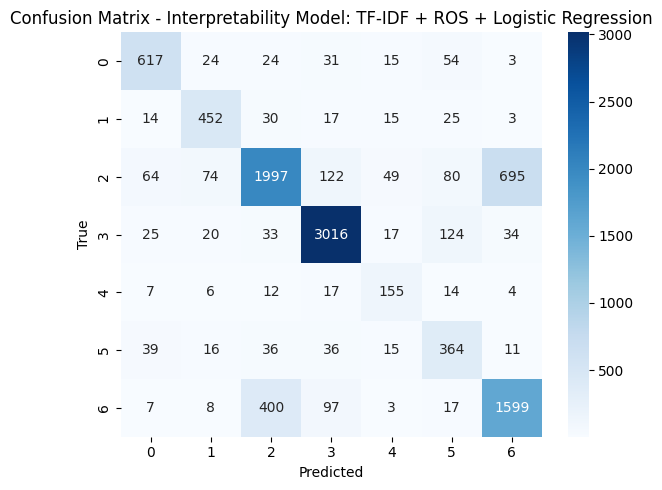

Interpretability model F1: 0.7387336848581357


In [23]:
ros_int = RandomOverSampler(random_state=42)
X_tfidf_ros_full, y_tfidf_ros_full = ros_int.fit_resample(X_tfidf_train, y_train)

lr_interp = LogisticRegression(
    max_iter=500,
    n_jobs=-1,
    multi_class="multinomial",
    solver="lbfgs"
)
print("Training interpretability model (TF-IDF + ROS + LR)...")
lr_interp.fit(X_tfidf_ros_full, y_tfidf_ros_full)

pred_interp, f1_interp = evaluate_model(
    lr_interp, X_tfidf_test, y_test,
    "Interpretability Model: TF-IDF + ROS + Logistic Regression"
)
print("Interpretability model F1:", f1_interp)


Fitting SHAP LinearExplainer (this may take a bit)...
Computing SHAP values on sample...


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)
The figure layout has changed to tight
The figure layout has changed to tight


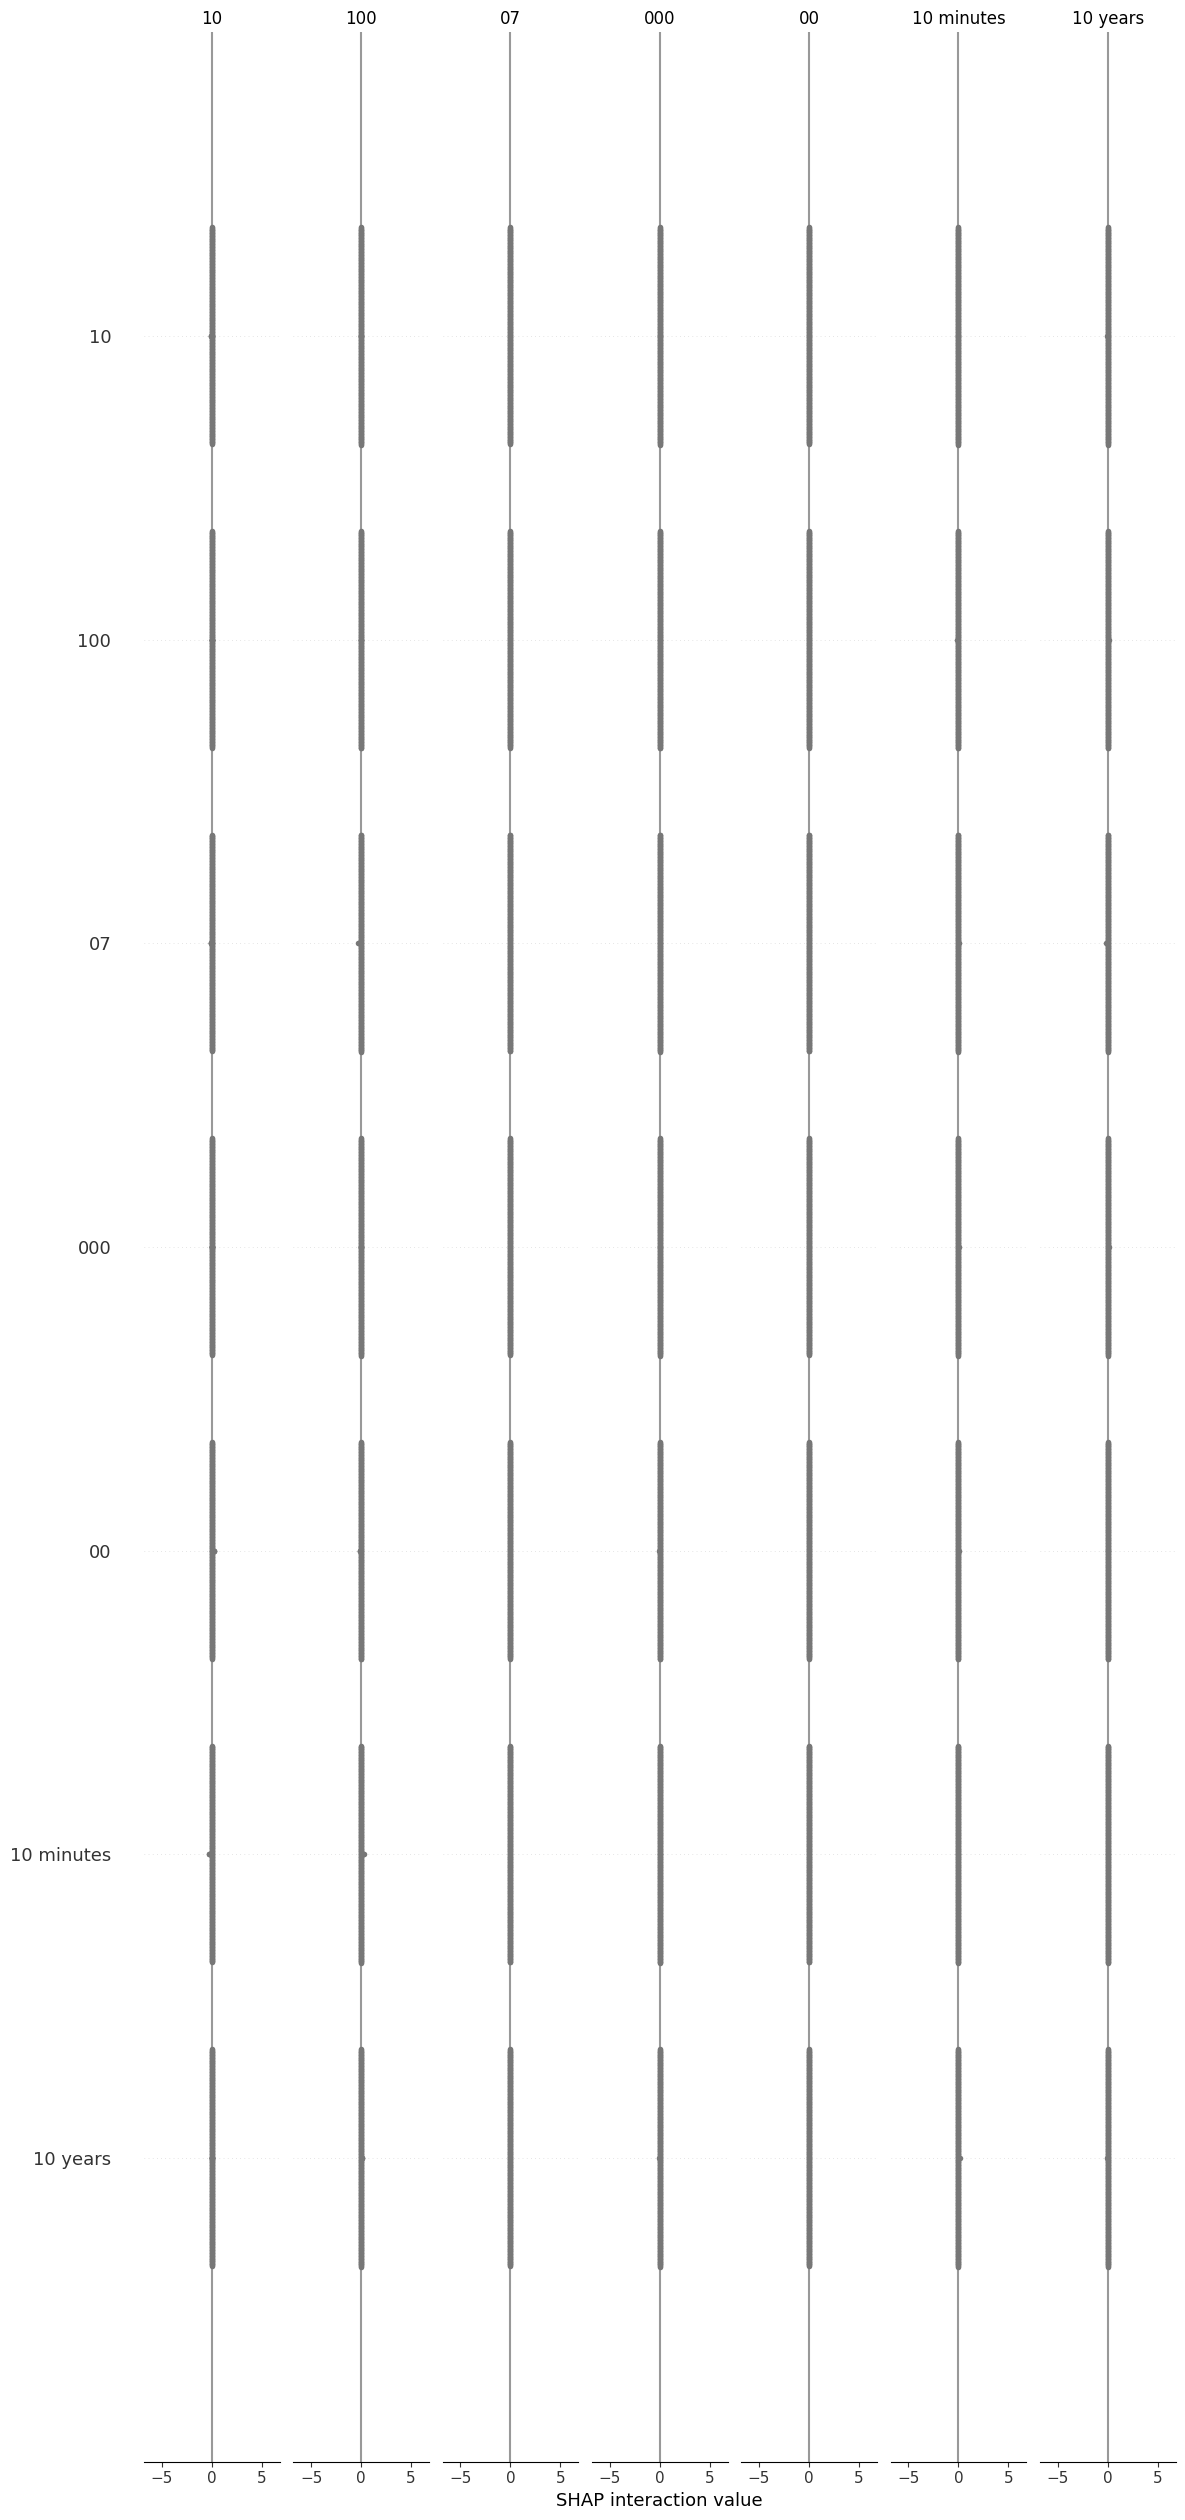

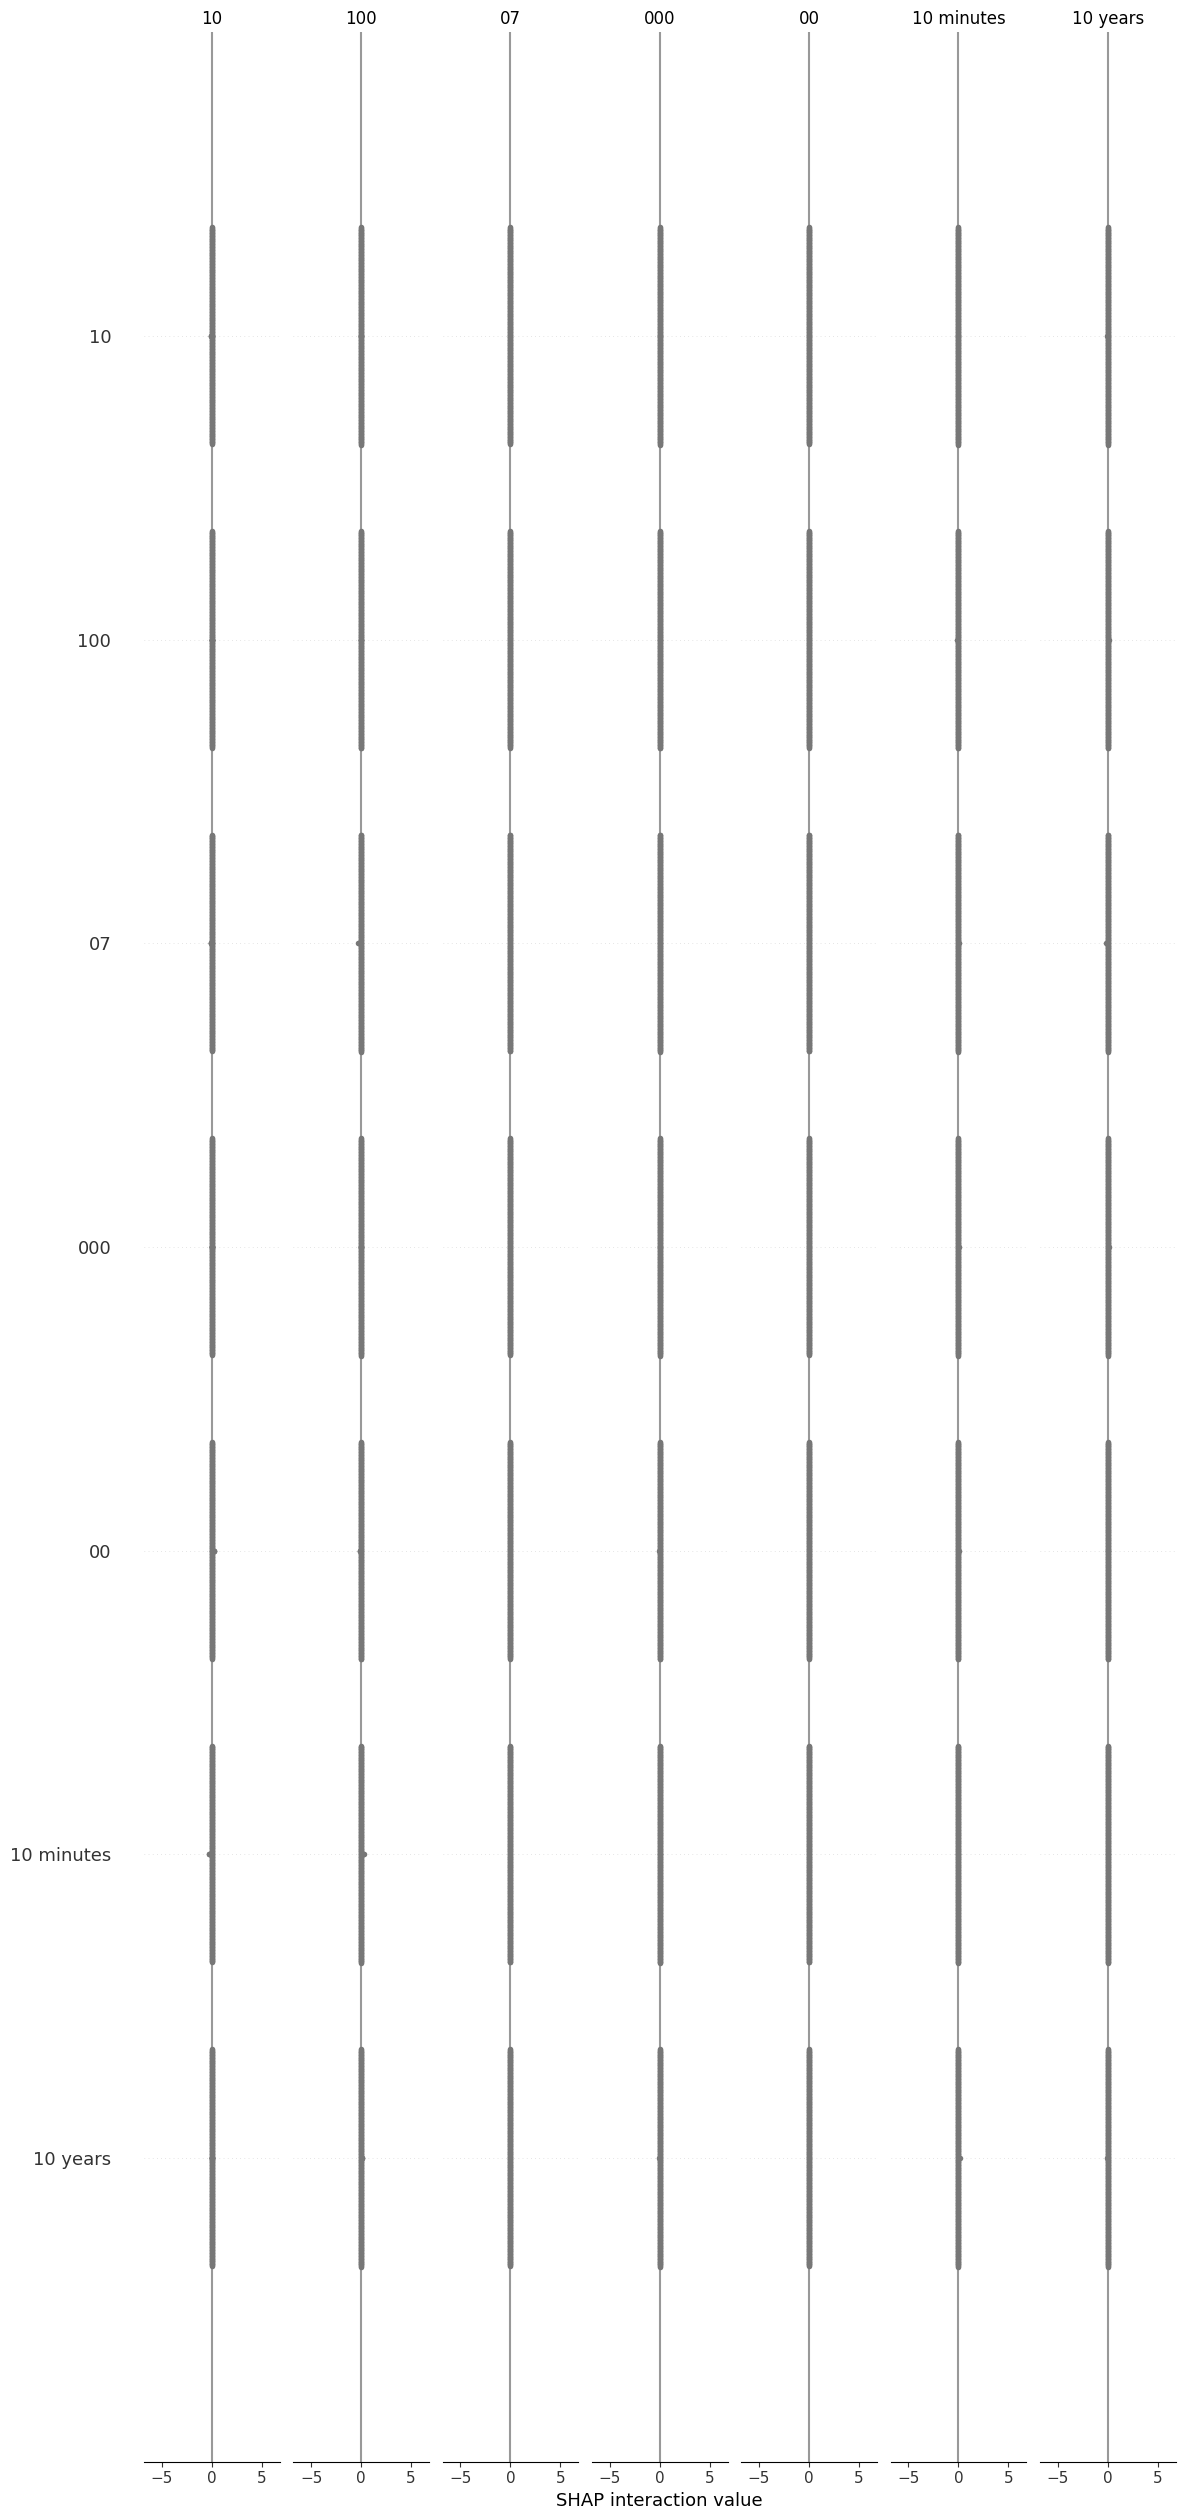

In [24]:
print("Fitting SHAP LinearExplainer (this may take a bit)...")
explainer = shap.LinearExplainer(lr_interp, X_tfidf_ros_full, feature_perturbation="interventional")

# Sample 300 test points for SHAP
sample_n  = min(300, X_tfidf_test.shape[0])
sample_idx = np.random.choice(X_tfidf_test.shape[0], sample_n, replace=False)
X_sample   = X_tfidf_test[sample_idx]

print("Computing SHAP values on sample...")
shap_values = explainer(X_sample)

feature_names = tfidf.get_feature_names_out()

# Beeswarm summary (global distribution)
shap.summary_plot(
    shap_values.values,
    X_sample,
    feature_names=feature_names,
    max_display=30
)

# Bar plot of mean |SHAP| (global importance)
shap.summary_plot(
    shap_values.values,
    X_sample,
    feature_names=feature_names,
    plot_type="bar",
    max_display=30
)


In [25]:
# Build a "heatmap" of SHAP values for top 20 features across first 50 samples
abs_mean_shap = np.mean(np.abs(shap_values.values), axis=0)  # (n_features,)
top_idx = np.argsort(abs_mean_shap)[-20:]  # top 20
top_features = feature_names[top_idx]

# take first 50 samples (or less)
n_show = min(50, X_sample.shape[0])
shap_top = shap_values.values[:n_show, :][:, top_idx]  # (samples, top_features)

plt.figure(figsize=(10, 6))
sns.heatmap(
    shap_top,
    cmap="coolwarm",
    center=0,
    yticklabels=False,
    xticklabels=top_features,
)
plt.title("SHAP value heatmap for top 20 features (first ~50 samples)")
plt.xlabel("Feature")
plt.ylabel("Sample")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


ValueError: Must pass 2-d input. shape=(50, 20, 7, 7)

<Figure size 1000x600 with 0 Axes>

In [26]:
# Pick one example in the sample
idx_local = 0
global_idx = sample_idx[idx_local]

print("TEXT:")
print(X_test_text[global_idx])
print("True label   :", y_test[global_idx])
print("Pred (interp):", pred_interp[global_idx])

# shap.waterfall requires a 1D shap vector
shap.plots.waterfall(
    shap.Explanation(
        values=shap_values.values[idx_local],
        base_values=explainer.expected_value,
        feature_names=feature_names,
        data=X_sample[idx_local].toarray().ravel() if hasattr(X_sample[idx_local], "toarray") else X_sample[idx_local]
    ),
    max_display=20
)


TEXT:
yes, we need a relaxed president who thinks clearly.
True label   : Normal
Pred (interp): Normal


ValueError: The waterfall plot can currently only plot a single explanation, but a matrix of explanations (shape (15000, 7)) was passed! Perhaps try `shap.plots.waterfall(shap_values[0])` or for multi-output models, try `shap.plots.waterfall(shap_values[0, 0])`.

NameError: name 'df' is not defined